In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import config
import utils
import reader

import jsonlines as jsonl
import json 

In [3]:
## util
import os
import logging
from argparse import ArgumentParser
from tqdm import tqdm_notebook as tqdmnb
from tqdm import tqdm as tqdm
import pickle
import json 
import jsonlines as jsonl
from collections import defaultdict
from typing import Iterable, List, Dict, Tuple, Union
from pathlib import Path
## graph
import networkx as nx
import matplotlib.pyplot as plt
## nn
import numpy as np
import torch
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
from torch_geometric.data import DataLoader
## Stanza
import stanza
from stanza.models.common.doc import Document
from stanza.pipeline.core import Pipeline
## allennlp model
from allennlp_models.structured_prediction.predictors.srl import SemanticRoleLabelerPredictor
from allennlp_models.structured_prediction.predictors.biaffine_dependency_parser import BiaffineDependencyParserPredictor
from allennlp.predictors.predictor import Predictor #
## allennlp
from allennlp.data import Token, Vocabulary, Instance
from allennlp.data.fields import ListField, TextField, Field
from allennlp.data.token_indexers import (
    SingleIdTokenIndexer,
    TokenCharactersIndexer,
    ELMoTokenCharactersIndexer,
    PretrainedTransformerIndexer,
    PretrainedTransformerMismatchedIndexer,
)
from allennlp.data.tokenizers import (
    CharacterTokenizer,
    PretrainedTransformerTokenizer,
    SpacyTokenizer,
    WhitespaceTokenizer,
)
from allennlp.modules.seq2vec_encoders import CnnEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import (
    Embedding,
    TokenCharactersEncoder,
    ElmoTokenEmbedder,
    PretrainedTransformerEmbedder,
    PretrainedTransformerMismatchedEmbedder,
)
from allennlp.nn import util as nn_util

In [4]:
file_path = config.P_TEST_FILE
print(file_path)

/work/2020-IIS-NLU-internship/MNLI/data/MNLI_Stanza/pre_multinli_1.0_dev_mismatched.jsonl


In [5]:
def read(filepath):
    with open(file_path, "r") as fo:
        example_iter = (json.loads(line) for line in fo)
        filtered_example_iter = (
            example for example in example_iter if example["gold_label"] != "-"
        )
        for example in filtered_example_iter:
            label = example["gold_label"]
            premise = example["sentence1"]
            hypothesis = example["sentence2"]
            yield (premise, hypothesis, label)

In [6]:
rd = read(file_path)

In [7]:
doc = next(iter(rd))[0]

In [8]:
g = utils.doc2graph(doc) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[(0, 3), (2, 1), (3, 2), (3, 4), (3, 17), (4, 5), (4, 6), (6, 10), (10, 7), (10, 8), (10, 9), (10, 12), (10, 16), (12, 11), (16, 13), (16, 14), (16, 15)]


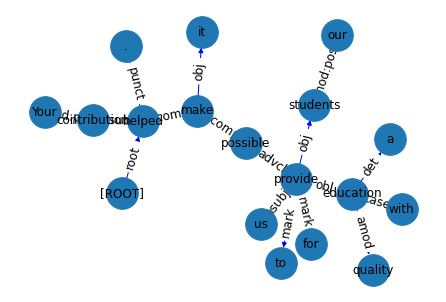

In [9]:
utils.draw(g)

In [10]:
utils.g2sent(g)

'[ROOT] Your contribution helped make it possible for us to provide our students with a quality education .'

In [183]:
# for namespace reuse
import reader

In [189]:
rd = reader.NLI_Graph_Reader()

In [190]:
dset3 = rd.read(config.P_DEV_FILE) # ajacency field

In [49]:
dir(dset[0])

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_abc_impl',
 'add_field',
 'as_tensor_dict',
 'count_vocab_items',
 'duplicate',
 'fields',
 'get',
 'get_padding_lengths',
 'index_fields',
 'indexed',
 'items',
 'keys',
 'values']

In [47]:
dset[0].fields

{'tokens_p': <allennlp.data.fields.text_field.TextField at 0x7fa189a1b0f0>,
 'tokens_h': <allennlp.data.fields.text_field.TextField at 0x7fa189a1b140>,
 'edge_p': <allennlp.data.fields.metadata_field.MetadataField at 0x7fa189a1c850>,
 'edge_h': <allennlp.data.fields.metadata_field.MetadataField at 0x7fa189a1c8d0>,
 'edge_type_p': <allennlp.data.fields.metadata_field.MetadataField at 0x7fa189a1c610>,
 'edge_type_h': <allennlp.data.fields.metadata_field.MetadataField at 0x7fa189a1ca90>,
 'label': <allennlp.data.fields.label_field.LabelField at 0x7fa189a1b190>}

In [43]:
dset[0].fields["tokens_p"].tokens

[[ROOT], The, new, rights, are, nice, enough]

In [45]:
dset[0].fields["tokens_h"].tokens

[[ROOT], Everyone, really, likes, the, newest, benefits]

In [56]:
def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)

In [58]:
build_vocab(dset[:10])

Building the vocabulary


Vocabulary with namespaces:  Non Padded Namespaces: {'*tags', '*labels'}

In [152]:
def allennlp_collate(instances: List[Instance]): # -> TensorDict:
    batch = Batch(instances)
    return batch.as_tensor_dict(batch.get_padding_lengths())

In [157]:
d = dset2[:2]

In [160]:
d[1].fields

{'tokens_p': <allennlp.data.fields.text_field.TextField at 0x7f9fe93f6230>,
 'tokens_h': <allennlp.data.fields.text_field.TextField at 0x7f9fe93f6e60>,
 'label': <allennlp.data.fields.label_field.LabelField at 0x7f9fe93f6280>}

In [169]:
vocab = Vocabulary.from_instances(d)
for data in d:
    data.index_fields(vocab)

In [172]:
batch = allennlp_collate(d)

In [174]:
batch

{'tokens_p': {'tokens': {'token_ids': tensor([[ 101, 1031, 7117, 1033, 1996, 2047, 2916, 2024, 3835, 2438,  102,    0,
               0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
           [ 101, 1031, 7117, 1033, 2023, 2609, 2950, 1037, 2862, 1997, 2035, 2400,
            4791, 1998, 1037, 3945, 3085, 7809, 1997, 2231, 3237, 4790, 1012,  102]]),
   'mask': tensor([[ True,  True,  True,  True,  True,  True,  True, False, False, False,
            False, False, False, False, False, False, False, False, False],
           [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             True,  True,  True,  True,  True,  True,  True,  True,  True]]),
   'type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
   'wordpiece_mask': tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
             Tr

In [192]:
dset3[0].fields

{'tokens_p': <allennlp.data.fields.text_field.TextField at 0x7f9fe476a140>,
 'tokens_h': <allennlp.data.fields.text_field.TextField at 0x7f9fe476a0f0>,
 'edge_p': <allennlp.data.fields.adjacency_field.AdjacencyField at 0x7f9fe4745fb0>,
 'edge_h': <allennlp.data.fields.adjacency_field.AdjacencyField at 0x7f9fe47790b0>,
 'label': <allennlp.data.fields.label_field.LabelField at 0x7f9fe4d754b0>}

In [197]:
print(type(dset3[0].fields["edge_p"]), dir(dset3[0].fields["edge_p"]))

<class 'allennlp.data.fields.adjacency_field.AdjacencyField'> ['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_already_warned_namespaces', '_indexed_labels', '_label_namespace', '_maybe_warn_for_namespace', '_padding_value', 'as_tensor', 'batch_tensors', 'count_vocab_items', 'duplicate', 'empty_field', 'get_padding_lengths', 'index', 'indices', 'labels', 'sequence_field']


In [200]:
d = dset3[:10]

In [295]:
vocab = Vocabulary.from_instances(dset3, non_padded_namespaces=["edge_labels"])

In [216]:
vocab.get_namespaces()

{'edge_labels', 'tags'}

In [213]:
batch = Batch(d)

In [215]:
batch.index_instances(vocab)

In [230]:
batch.as_tensor_dict(batch.get_padding_lengths())["edge_p"].size()

torch.Size([10, 48, 48])

In [246]:
True in (batch.as_tensor_dict(batch.get_padding_lengths())["edge_p"] != -1) # tensor overrides __contain__

True

In [265]:
print(vocab)
print((batch.as_tensor_dict(batch.get_padding_lengths())["edge_p"] == 30).__contains__(True))
print((batch.as_tensor_dict(batch.get_padding_lengths())["edge_h"] == 30).__contains__(True))
print((batch.as_tensor_dict(batch.get_padding_lengths())["edge_p"] == 31).__contains__(True))
print((batch.as_tensor_dict(batch.get_padding_lengths())["edge_h"] == 31).__contains__(True))

Vocabulary with namespaces:
 	Non Padded Namespaces: {'edge_labels'}
 	Namespace: edge_labels, Size: 31 
 	Namespace: tags, Size: 30524 

False
True
False
False


In [270]:
dir(vocab)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_extend',
 '_index_to_token',
 '_non_padded_namespaces',
 '_oov_token',
 '_padding_token',
 '_registry',
 '_retained_counter',
 '_token_to_index',
 'add_token_to_namespace',
 'add_tokens_to_namespace',
 'by_name',
 'default_implementation',
 'empty',
 'extend_from_instances',
 'extend_from_vocab',
 'from_files',
 'from_files_and_instances',
 'from_instances',
 'from_params',
 'get_index_to_token_vocabulary',
 'get_namespaces',
 'get_token_from_index',
 'get_token_index',
 'get_token_to_index_vocabulary',
 'get_vocab_size',
 'is_padded',
 'list_available',
 'print_stat

In [274]:
vocab.print_statistics()



----Vocabulary Statistics----


Top 10 most frequent tokens in namespace 'edge_labels':
	Token: nsubj		Frequency: 45
	Token: case		Frequency: 35
	Token: det		Frequency: 34
	Token: obj		Frequency: 23
	Token: amod		Frequency: 22
	Token: root		Frequency: 20
	Token: advmod		Frequency: 20
	Token: punct		Frequency: 20
	Token: obl		Frequency: 20
	Token: aux		Frequency: 17

Top 10 longest tokens in namespace 'edge_labels':
	Token: compound:prt		length: 12	Frequency: 2
	Token: nmod:npmod		length: 10	Frequency: 1
	Token: nsubj:pass		length: 10	Frequency: 1
	Token: acl:relcl		length: 9	Frequency: 6
	Token: discourse		length: 9	Frequency: 5
	Token: nmod:poss		length: 9	Frequency: 5
	Token: parataxis		length: 9	Frequency: 1
	Token: obl:npmod		length: 9	Frequency: 1
	Token: compound		length: 8	Frequency: 8
	Token: aux:pass		length: 8	Frequency: 2

Top 10 shortest tokens in namespace 'edge_labels':
	Token: cc		length: 2	Frequency: 12
	Token: acl		length: 3	Frequency: 4
	Token: cop		length: 3	Freque

In [277]:
print(dir(batch.as_tensor_dict()))

['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


In [283]:
bt = batch.as_tensor_dict()
print(bt.keys())

dict_keys(['tokens_p', 'tokens_h', 'edge_p', 'edge_h', 'label'])


In [285]:
bt["tokens_p"].keys()

dict_keys(['tokens'])

In [288]:
bt["tokens_p"]["tokens"].keys()

dict_keys(['token_ids', 'mask', 'type_ids', 'wordpiece_mask', 'offsets'])

In [289]:
# but we want sparse graph for graph nn intead of dense graph

In [293]:
b2 = Batch(dset3[:32])

In [301]:
b2.index_instances(vocab)
b2t = b2.as_tensor_dict(b2.get_padding_lengths())

In [302]:
b2t.keys()

dict_keys(['tokens_p', 'tokens_h', 'edge_p', 'edge_h', 'label'])

In [303]:
b2t["edge_p"].size()

torch.Size([32, 96, 96])

In [308]:
class GraphField(Field[Dict[str, torch.Tensor]]):
    def __init__():
        surper

In [313]:
#b2.as_tensor_dict(verbose=True)

In [319]:
import reader

In [684]:
del SparseAdjacencyField
from sparse_adjacency_field import SparseAdjacencyField

In [665]:
torch.rand((5,5))[(1,2)]

tensor(0.9929)

In [685]:
pygd = Data(edge_index=torch.tensor([[0,1], [1,0]]), edge_attr=["e0", "e1"])
pygd
seqf = TextField([Token("v0"), Token("vi")], token_indexers={"tokens":SingleIdTokenIndexer(namespace='tokens')})
seqf2 = TextField([Token("v2"), Token("vi"), Token("v0")], token_indexers={"tokens":SingleIdTokenIndexer(namespace='tokens')})

In [686]:
pygd2 = Data(edge_index=torch.tensor([[0,1, 2], [1,0,2]]), edge_attr=["e2", "e1", "e3"])
pygd2

Data(edge_attr=[3], edge_index=[2, 3])

In [687]:
spaf = SparseAdjacencyField(pygd, sequence_field=seqf)

In [688]:
spaf2 = SparseAdjacencyField(pygd2, sequence_field=seqf2)

In [689]:
vocab2 = Vocabulary.from_instances(instances=[spaf, spaf2])

In [690]:
#bat = Batch([spaf, spaf2])
print(vocab2.get_namespaces())

{'edge_labels'}


In [691]:
spaf.index(vocab2)
spaf2.index(vocab2)

In [692]:
t1 = spaf.as_tensor(spaf.get_padding_lengths())
t2 = spaf2.as_tensor(spaf.get_padding_lengths())
print(t1, t2, sep='\n')

{'edge_attr': tensor([1, 0]), 'edge_index': tensor([[0, 1],
        [1, 0]]), 'batch_id': tensor([0., 0.])}
{'edge_attr': tensor([2, 0, 3]), 'edge_index': tensor([[0, 1, 2],
        [1, 0, 2]]), 'batch_id': tensor([0., 0., 0.])}


In [693]:
bt3 = spaf.batch_tensors([t1, t2, t1])
bt3

{'edge_index': tensor([[0, 1, 2, 3, 4, 5, 6],
         [1, 0, 3, 2, 4, 6, 5]]),
 'edge_attr': tensor([1, 0, 2, 0, 3, 1, 0]),
 'batch_id': tensor([0, 0, 1, 1, 1, 2, 2])}

In [694]:
spaf.empty_field()

In [695]:
print(dir(Token("x")))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', 'dep_', 'ent_type_', 'idx', 'idx_end', 'lemma_', 'pos_', 'tag_', 'text', 'text_id', 'type_id']


In [696]:
del reader 
import reader

In [699]:
rdr = reader.NLI_Graph_Reader()

[autoreload of sparse_adjacency_field failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'SparseAdjacencyField' object layout differs from 'SparseAdjacencyField'
]
